In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from bisect import bisect_left

In [40]:
windmodel = load_model('C:/Users/Avishai/Desktop/Senior-project/Ml/wind/WindModel.h5')
nuclearmodel = load_model('C:/Users/Avishai/Desktop/Senior-project/Ml/Nukes/NuclearModel.h5')
hydromodel = load_model('C:/Users/Avishai/Desktop/Senior-project/Ml/Hydroelectric/HydroModel.h5')
solarmodel = load_model('C:/Users/Avishai/Desktop/Senior-project/Ml/solar/SolarModel.h5')

In [41]:
testdata = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/outputtestdata.csv')
trainingdata = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')
testdata['Sum'] = testdata['NetLoadMw']
testdata['BeginDate'] = pd.to_datetime(testdata['BeginDate']).dt.tz_localize(None)
testdata['Previous_Day'] = testdata['BeginDate'] - pd.Timedelta(days=1)
testdata['Previous_2Day'] = testdata['BeginDate'] - pd.Timedelta(days=2)
testdata['Previous_Year'] = testdata['BeginDate'] - pd.DateOffset(years=1)
data2find = testdata[['Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_52296\3461475818.py:2: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  trainingdata = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')


In [42]:
# Load your data (assuming trainingdata has 'BeginDate', 'Solar', 'Wind', 'Hydro', 'Nuclear' columns)
trainingdata['BeginDate'] = pd.to_datetime(trainingdata['BeginDate']).dt.tz_localize(None)

# Sort trainingdata by BeginDate to allow for efficient nearest date search
trainingdata = trainingdata.sort_values('BeginDate').reset_index(drop=True)

# Initialize an empty list to store results
results = []

# Define a function to find the closest date
def find_nearest_date(date, df):
    """Find the nearest date in the DataFrame for a given date."""
    diffs = (df['BeginDate'] - date).abs()
    nearest_idx = diffs.idxmin()
    return df.loc[nearest_idx]

# Iterate over each row in data2find
for idx, row in data2find.iterrows():
    row_result = {}
    
    # For each renewable type and each previous date, find the nearest date's output
    for energy_type in ['Solar', 'Wind', 'Hydro', 'Nuclear']:
        # Get the nearest data for Previous_Day, Previous_2Day, and Previous_Year
        previous_day_data = find_nearest_date(row['Previous_Day'], trainingdata)
        previous_2day_data = find_nearest_date(row['Previous_2Day'], trainingdata)
        previous_year_data = find_nearest_date(row['Previous_Year'], trainingdata)
        
        # Store the values for each energy type
        row_result[f'Previous_Day_{energy_type}'] = previous_day_data[energy_type]
        row_result[f'Previous_2Day_{energy_type}'] = previous_2day_data[energy_type]
        row_result[f'Previous_Year_{energy_type}'] = previous_year_data[energy_type]
    
    # Append the result to the results list
    results.append(row_result)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)
# Assuming testdata and results_df have the same number of rows
combined_data = pd.concat([testdata.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

# Display the combined DataFrame
print(combined_data.head())



            BeginDate                   CreationDate  LoadMw  NetLoadMw  \
0 2024-10-28 04:00:00  2024-10-28T09:18:17.000-04:00   10080      10080   
1 2024-10-28 05:00:00  2024-10-28T09:18:17.000-04:00    9790       9790   
2 2024-10-28 06:00:00  2024-10-28T09:18:17.000-04:00    9660       9660   
3 2024-10-28 07:00:00  2024-10-28T09:18:17.000-04:00    9710       9710   
4 2024-10-28 08:00:00  2024-10-28T09:18:17.000-04:00   10060      10060   

                    datetime  temp   dew  humidity  precip preciptype  ...  \
0  2024-10-28 04:00:00+00:00  42.9  29.9     59.66     0.0        NaN  ...   
1  2024-10-28 05:00:00+00:00  42.0  31.8     66.90     0.0        NaN  ...   
2  2024-10-28 06:00:00+00:00  38.8  30.8     72.57     0.0        NaN  ...   
3  2024-10-28 07:00:00+00:00  38.0  29.0     69.96     0.0        NaN  ...   
4  2024-10-28 08:00:00+00:00  39.7  29.9     67.58     0.0        NaN  ...   

   Previous_Year_Solar  Previous_Day_Wind  Previous_2Day_Wind  \
0              

In [48]:
from sklearn.preprocessing import StandardScaler
combined_data['Hour_of_Day'] = combined_data['BeginDate'].dt.hour
combined_data['Minute'] = combined_data['BeginDate'].dt.minute
combined_data['Month'] = combined_data['BeginDate'].dt.month
combined_data['Year'] = combined_data['BeginDate'].dt.year
inputdatahydro = combined_data[['Month','Previous_Day_Hydro','Previous_2Day_Hydro','Sum','Hour_of_Day','Previous_Year_Hydro','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]
inputdatanuclear = combined_data[['Previous_Day_Nuclear','Month','Previous_2Day_Nuclear','Sum','Hour_of_Day','Previous_Year_Nuclear','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]
inputdatawind = combined_data[['Month','Year','Previous_Year_Wind','Previous_2Day_Wind','Sum','snowdepth','temp','solarenergy','sealevelpressure', 'humidity','solarenergy','snow', 'precip', 'uvindex', 'cloudcover', 'Previous_Day_Wind','Hour_of_Day','dew','windgust','windspeed','winddir']]
inputdatasolar = combined_data[['Month','Year','Previous_Year_Solar','Previous_2Day_Solar','Sum','temp', 'humidity', 'precip', 'uvindex', 'cloudcover', 'solarradiation','Previous_Day_Solar','solarenergy','Hour_of_Day','dew','dew','snow','snowdepth','windspeed','windgust']]
scalar = StandardScaler()
inputdatahydro = scalar.fit_transform(inputdatahydro)
inputdatanuclear = scalar.fit_transform(inputdatanuclear)
inputdatawind = scalar.fit_transform(inputdatawind)
inputdatasolar = scalar.fit_transform(inputdatasolar)

In [53]:
hydropredictions = hydromodel.predict(inputdatahydro)
hydropredictions[hydropredictions < 0] = 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [54]:
nuclearpredictions = nuclearmodel.predict(inputdatanuclear)
nuclearpredictions[nuclearpredictions < 0] = 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [55]:
windpredictions = windmodel.predict(inputdatawind)
windpredictions[windpredictions < 0] = 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [56]:
solarpredictions = solarmodel.predict(inputdatasolar)
solarpredictions[solarpredictions < 0] = 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


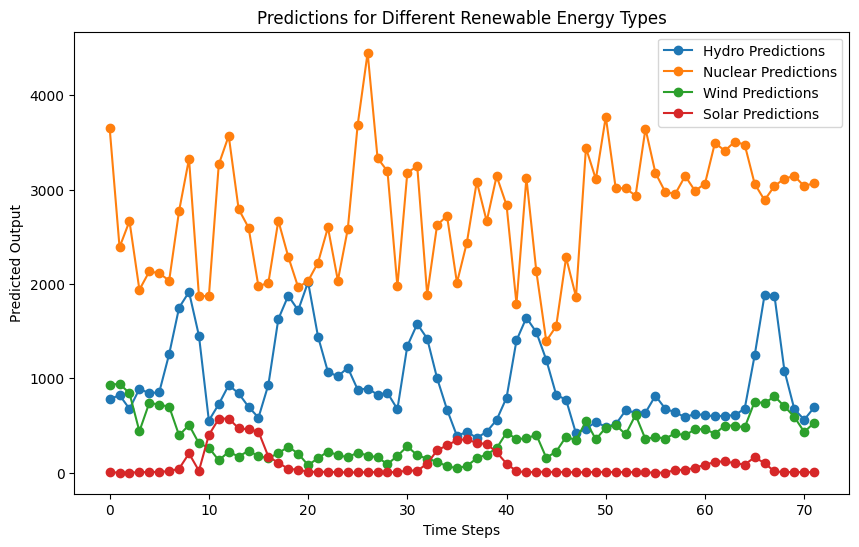

In [57]:
import matplotlib.pyplot as plt

# Sample data
# Assuming `hydropredictions`, `nuclearpredictions`, `windpredictions`, and `solarpredictions` 
# are lists or pandas Series containing prediction values for each energy type.

# Generate the plots
plt.figure(figsize=(10, 6))

# Plot each type of prediction
plt.plot(hydropredictions, label='Hydro Predictions', marker='o')
plt.plot(nuclearpredictions, label='Nuclear Predictions', marker='o')
plt.plot(windpredictions, label='Wind Predictions', marker='o')
plt.plot(solarpredictions, label='Solar Predictions', marker='o')

# Add labels and title
plt.xlabel('Time Steps')
plt.ylabel('Predicted Output')
plt.title('Predictions for Different Renewable Energy Types')

# Display legend
plt.legend()

# Show the plot
plt.show()


In [60]:
# Ensure each prediction variable is a 1D array
hydropredictions = pd.Series(hydropredictions.flatten())
nuclearpredictions = pd.Series(nuclearpredictions.flatten())
windpredictions = pd.Series(windpredictions.flatten())
solarpredictions = pd.Series(solarpredictions.flatten())

# Create the DataFrame with BeginDate and all predictions
output_df = pd.DataFrame({
    'BeginDate': testdata['BeginDate'],
    'HydroPredictions': hydropredictions,
    'NuclearPredictions': nuclearpredictions,
    'WindPredictions': windpredictions,
    'SolarPredictions': solarpredictions
})

# Write the DataFrame to a CSV file
output_df.to_csv('energy_predictions.csv', index=False)

print("Predictions successfully saved to 'energy_predictions.csv'")


Predictions successfully saved to 'energy_predictions.csv'
